In [1]:
import numpy as np

from scipy.interpolate import interp1d
from scipy import stats

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")

import time
timeformat = "%Y%m%d-%H%M%S"
#timestr = time.strftime(timeformat)


from IPython.utils.path import ensure_dir_exists
fdir = 'figs/'
ensure_dir_exists(fdir)
resdir = 'res/'
ensure_dir_exists(resdir)

import RBMF as rbmf

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
T     = 300
N     = 1000
frac  = 1.

seed0 = 0

Iinit0 = np.array(3)
iota0  = 0.2
rho0   = 0.02
delta0 = 0.01

figsize = (14,8)

In [3]:
params = {'T':    T, 
          'N':    N,
          'frac': frac}
freeparams = {'iota':  iota0,
              'rho':   rho0,
              'delta': delta0,
              'Iinit': Iinit0,
              'seed':  seed0}

In [4]:
def updateStates(rExc, S, I, R, D):
    if rExc == 0:         # Infection
        S -= 1
        I += 1
        return np.array(S), np.array(I), np.array(R), np.array(D)
    if rExc == 1:         # Recovery
        I -= 1
        R += 1
        return np.array(S), np.array(I), np.array(R), np.array(D)
    if rExc == 2:         # Death
        I -= 1
        D += 1
        return np.array(S), np.array(I), np.array(R), np.array(D)
    
def updatePropensities(S, I, R, D, N, iota, rho, delta):
    kappa = np.zeros(3)
    kappa[0] = S*I * iota/N # Infection
    kappa[1] =   I * rho    # Recovery
    kappa[2] =   I * delta  # Death
    return kappa

SIRD = rbmf.ModelSSA(name="SIRD",
                     params=params,
                     freeparams=freeparams,
                     update_states=updateStates,
                     update_propensities=updatePropensities)

## Data

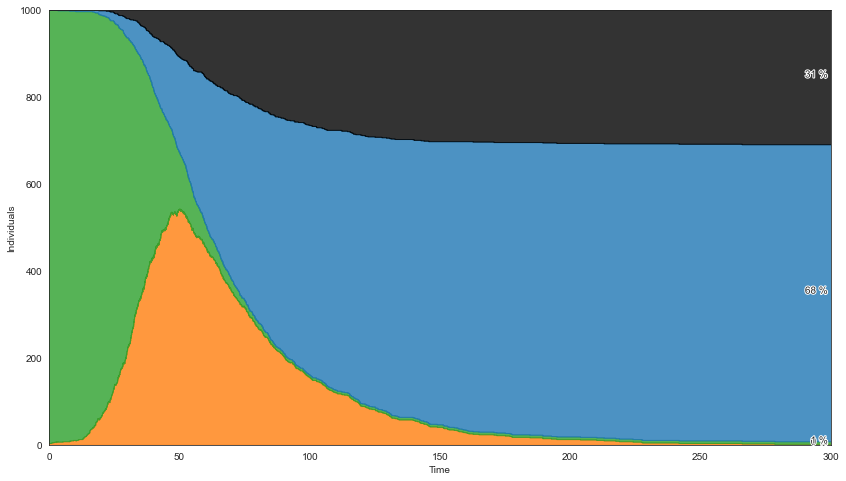

In [5]:
t0, S0, I0, R0, D0 = SIRD.simulate(freeparams)
fig = SIRD.plot(N, T, t0, S0, I0, R0, D0, ptitle=None, figsize=figsize, plegend=False)

## Distances

In [6]:
dfAll = interp1d(t0, (S0,I0,R0,D0), kind='previous', axis=- 1, fill_value='extrapolate', assume_sorted=True)
dfI   = interp1d(t0, I0, kind='previous', axis=- 1, fill_value='extrapolate', assume_sorted=True)
dfS   = interp1d(t0, S0, kind='previous', axis=- 1, fill_value='extrapolate', assume_sorted=True)
dfD   = interp1d(t0, D0, kind='previous', axis=- 1, fill_value='extrapolate', assume_sorted=True)

incI = -dfS((np.arange(T)))[1:] + dfS((np.arange(T)))[:-1]
incD =  dfD((np.arange(T)))[1:] - dfD((np.arange(T)))[:-1]

def distAllTabs(t, S, I, R, D):
    return (np.abs(dfAll(t) - [S,I,R,D])).sum()/(3*T*N) + np.abs(t0[-1] - t[-1])/T

def distAllabs(t, S, I, R, D):
    dfAlls = interp1d(t, (S, I, R, D), kind='previous', axis=- 1, copy=True, fill_value='extrapolate', assume_sorted=True)
    tu  = np.unique(np.hstack((t0,t,T)))
    dtu = tu[1:] - tu[:-1] 
    return (np.abs(dfAll(tu[:-1]) - dfAlls(tu[:-1]))*dtu).sum()/(8*N*T)

def distAll2(t, S, I, R, D):
    dfAlls = interp1d(t, (S, I, R, D), kind='previous', axis=- 1, copy=True, fill_value='extrapolate', assume_sorted=True)
    tu  = np.unique(np.hstack((t0,t,T)))
    dtu = tu[1:] - tu[:-1] 
    return np.sqrt(np.abs(dfAll(tu[:-1]) - dfAlls(tu[:-1]))**2 * dtu).sum()/(8*N*T)


def distIT2(t, S, I, R, D):
    return np.sqrt( ((dfI(t) - I)**2).sum())/(T*N) + np.abs(t0[-1] - t[-1])/T


def distIncIabs(t, S, I, R, D):
    dfs = interp1d(t, S, kind='previous', axis=- 1, copy=True, fill_value='extrapolate', assume_sorted=True)
    incIs = -dfs((np.arange(T)))[1:] + dfs((np.arange(T)))[:-1]
    return np.abs(incI - incIs).sum()/(2*N)

def distIncID2(t, S, I, R, D):
    dfs = interp1d(t, S, kind='previous', axis=- 1, copy=True, fill_value='extrapolate', assume_sorted=True)
    dfd = interp1d(t, D, kind='previous', axis=- 1, copy=True, fill_value='extrapolate', assume_sorted=True)
    
    incIs = -dfs((np.arange(T)))[1:] + dfs((np.arange(T)))[:-1]
    incDs =  dfd((np.arange(T)))[1:] - dfd((np.arange(T)))[:-1]
    return np.sqrt( np.sum((incI - incIs)**2) +  np.sum((incD - incDs)**2))/(4*N)

## Parameter Estimation (Model known) with ABC_MCMC

In [13]:
def ABC_MCMC(model, data, priors, tolerance, distance, statistics, proposal, paraminit, M, K, scale=0.1):
    freeparams = dict.fromkeys(model.freeparams.keys())
    nfreeparams = len(freeparams) 
    m, z = 0, 0
    samples = np.zeros((M, nfreeparams))
    distances = np.zeros(M)
    Hs = np.zeros(M)
    totalsamples = []
    
    thetaC = np.atleast_1d(paraminit)
    rC = 1.
    
    while m < M:
        print(f'({m:4} / {z:4})', end='\r')
        
        #sample from proposal q(.|thetaC)
        theta = np.atleast_1d(proposal.rvs(thetaC, scale))
        
        rk = 0.
        dk = 0.
        for k in range(K):
            ts, Ss, Is, Rs, Ds = model.simulate(dict(zip(freeparams.keys(), theta)))
            z += 1
            
            ds = distance(ts, Ss, Is, Rs, Ds)

            if ds < tolerance:
                rk += 1
                dk += ds 
        r = rk/K
        d = dk/K
        
        H = min(1., r/rC * proposal.pdf(thetaC, theta, scale)/proposal.pdf(theta, thetaC, scale))
                #priors.pdf(theta)/priors.pdf(thetaC) * 
        
        #print(H)
        if stats.uniform.rvs() <= H:
            thetaC = theta
            rC = r
            
            samples[m] = thetaC
            distances[m] = d
            m += 1
        totalsamples.append(thetaC)
    
    return np.squeeze(samples), np.squeeze(distances), z, np.squeeze(np.array(totalsamples))

In [8]:
SIRDiota = rbmf.ModelSSA(name="SIRDiota",
                         params={'T': T, 'N': N, 'frac': frac,'rho': rho0, 'delta': delta0, 'Iinit': Iinit0},
                         freeparams={'iota': 0.2},
                         update_states=updateStates,
                         update_propensities=updatePropensities)

In [29]:
model = SIRDiota
dist = distAll2
#dist = distIncID2

tolerance = 0.025
M = 1000

priors = stats.uniform(loc=0., scale=1.)
proposal = stats.norm
paraminit = 0.5

#samples, distances, z, totalSamples = ABC_MCMC(SIRDiota, None, priors, tolerance, distAll2, None, proposal, paraminit, M, 1)

In [30]:
tolerances = [1.0, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025]
runs = len(tolerances)
allSamples   = np.zeros((runs, M))
allDistances = np.zeros((runs, M))
allZ         = np.zeros(runs)
allTotalSamples = []

for r in range(runs):
    print(f'tolerance: {tolerances[r]}')
    samples, distances, z, totalSamples = ABC_MCMC(model, None, priors, tolerances[r], dist, None, proposal, paraminit, M, 1)
    allSamples[r,:] = samples
    allDistances[r,:] = distances
    allZ[r] = z
    allTotalSamples.append(totalSamples)
    print('\n')
    fn = "ABC_MCMC_" + model.name + f'({model.formulation})_' + f'tol{tolerances[r]}_M{M}_' + time.strftime(timeformat)
    np.savez(resdir + fn, samples=samples, distances=distances, z=z, totalSamples=totalSamples)
fn = 'ABC_MCMC_' + model.name + f'({model.formulation})_' + f'RUNS_M{M}_' + time.strftime(timeformat)    
np.savez(resdir + fn, allSamples=allSamples, allDistances=allDistances, allZ=allZ, allTotalSamples=allTotalSamples, tolerances=tolerances)

tolerance: 1.0
( 999 /  999)

tolerance: 0.5
( 999 / 1000)

tolerance: 0.25
( 999 / 1006)

tolerance: 0.1
( 999 / 2286)

tolerance: 0.075
( 999 / 3471)

tolerance: 0.05
( 999 / 5457)

tolerance: 0.025
( 999 / 13924)



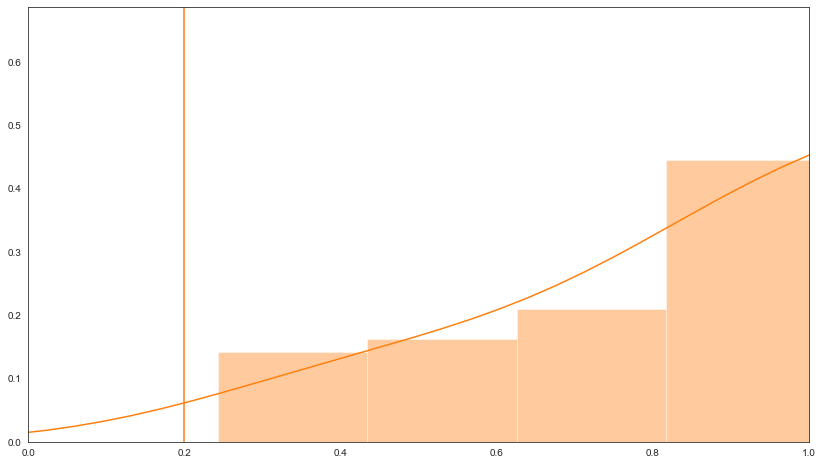

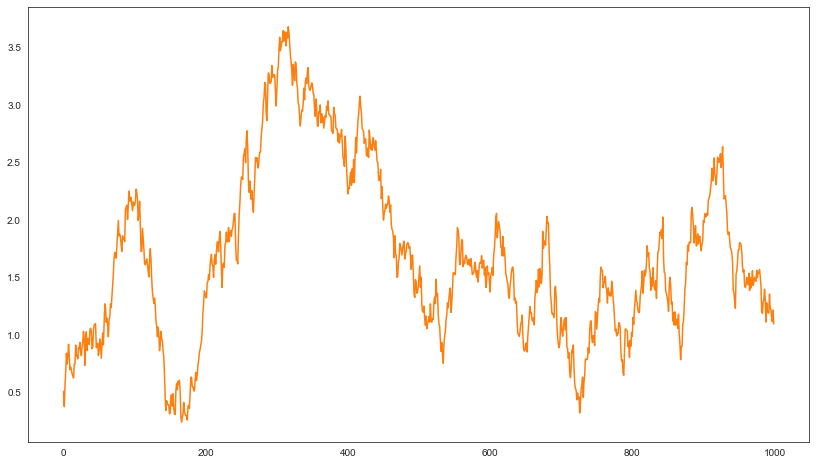

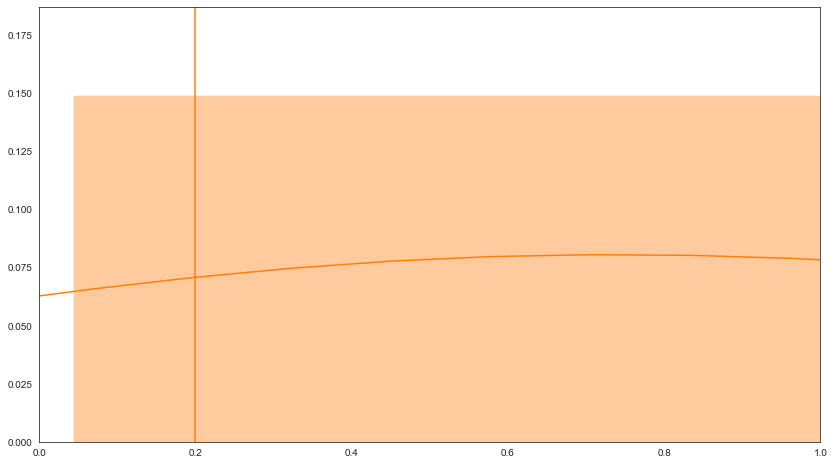

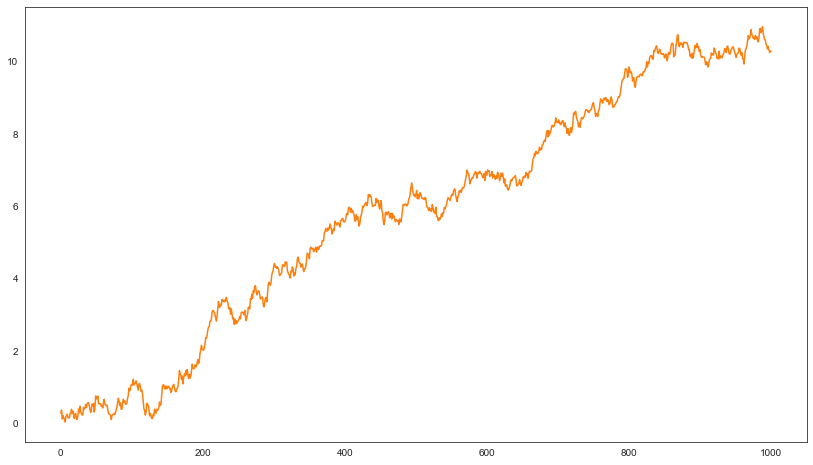

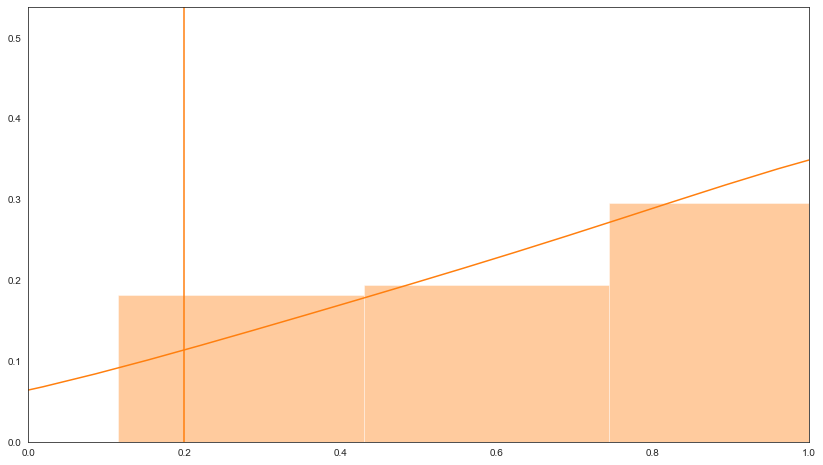

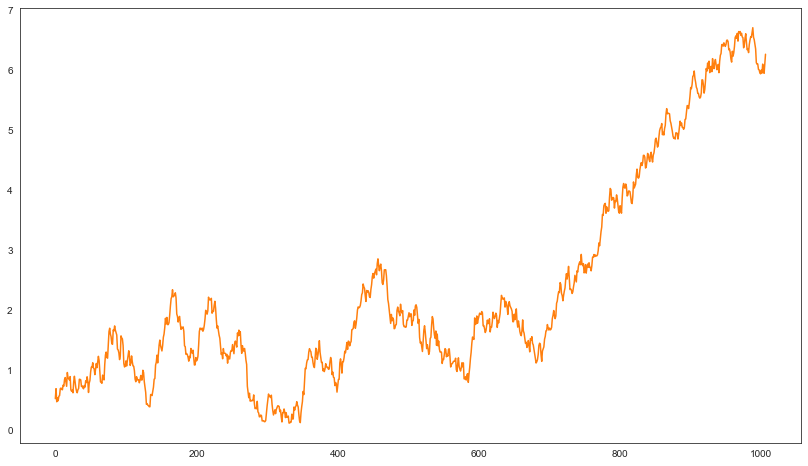

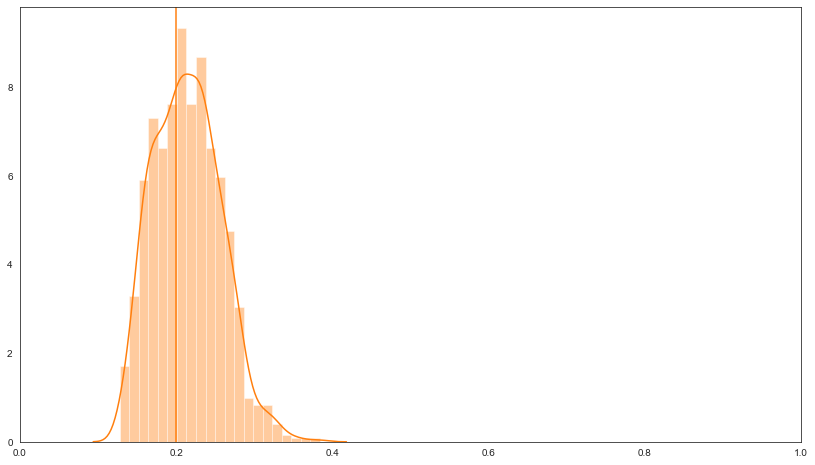

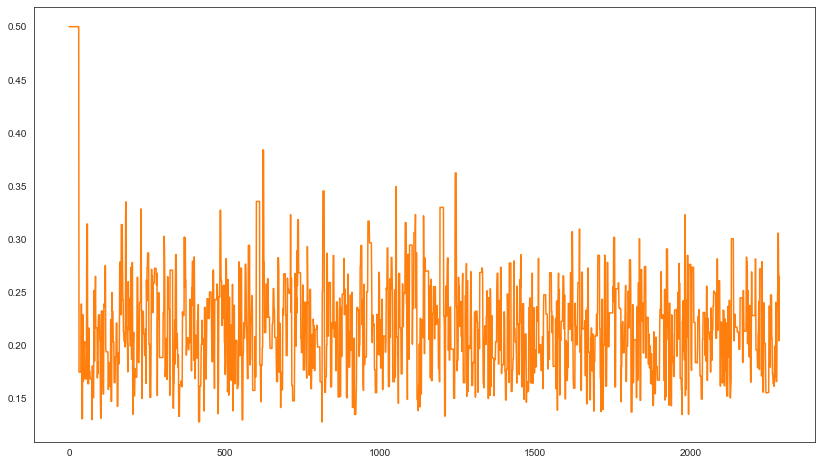

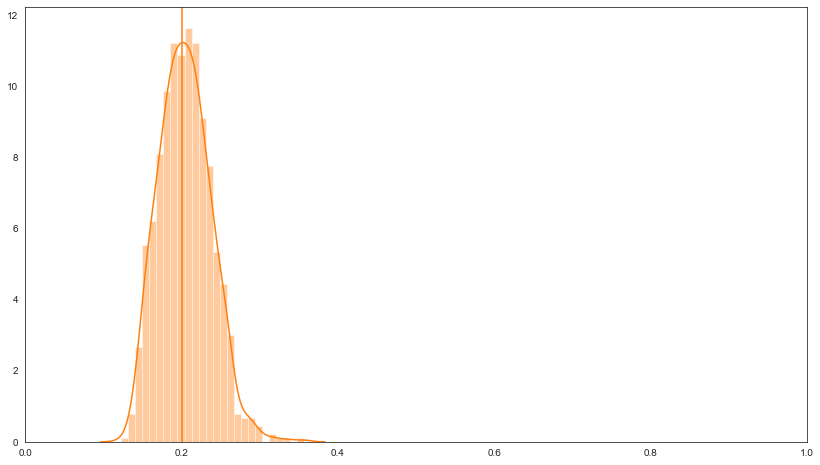

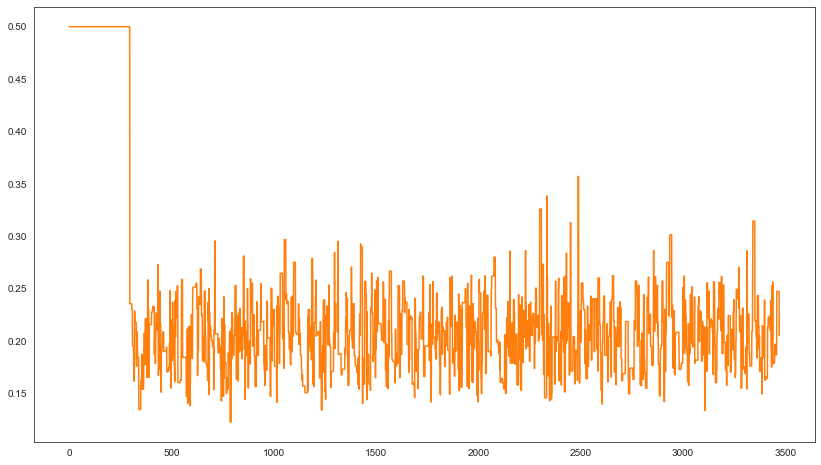

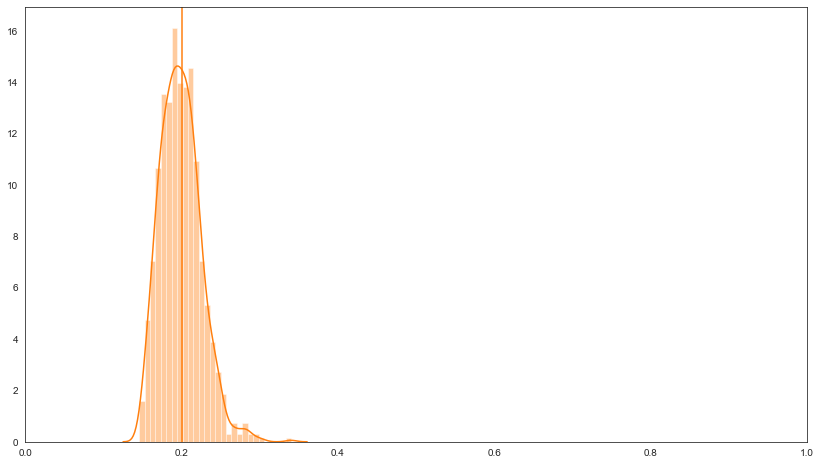

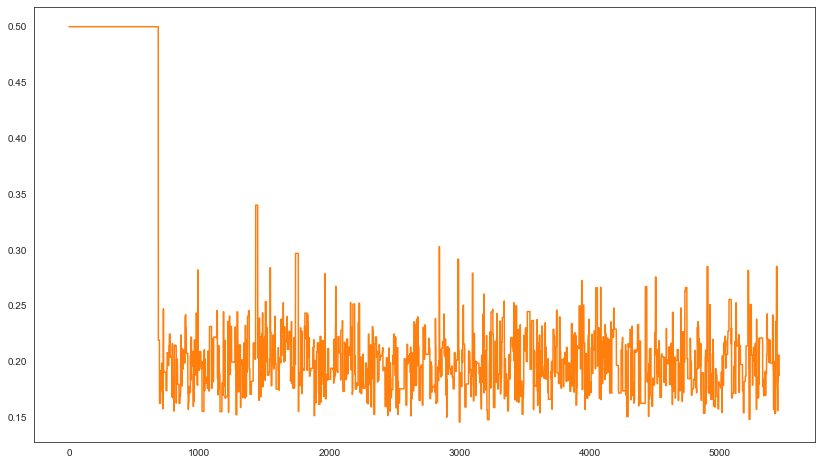

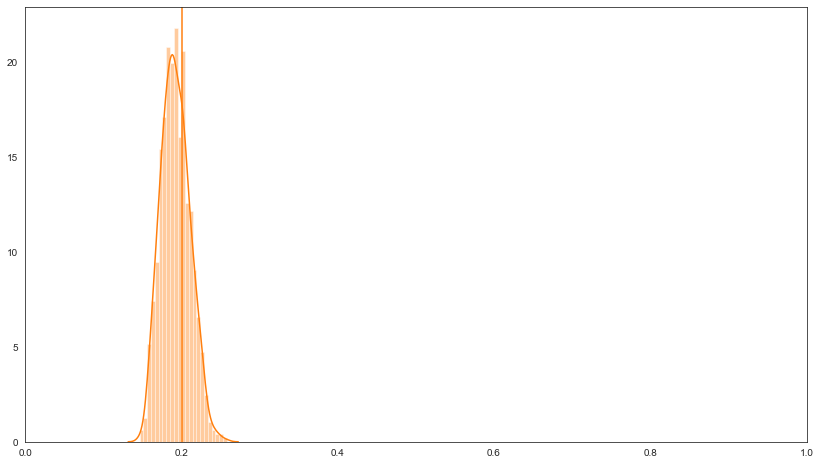

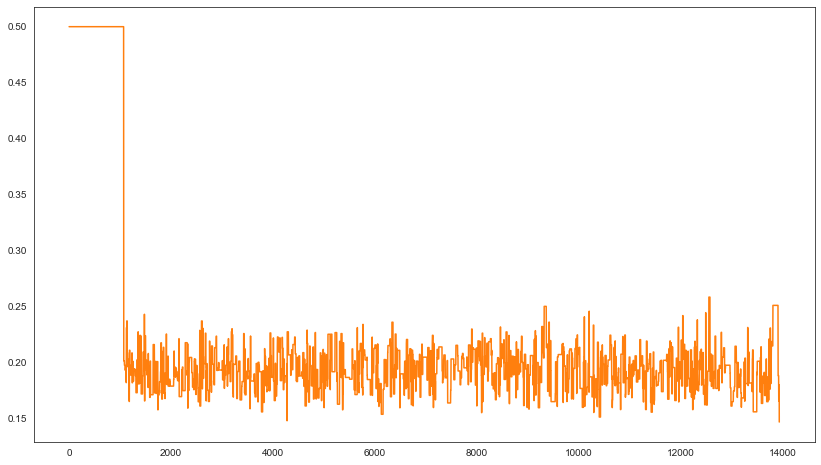

In [42]:
for r in range(runs):
    plt.figure(figsize=figsize)

    sns.distplot(allSamples[r,:], color='tab:orange')
    plt.axvline(iota0, c='tab:orange')

    plt.xlim((0,1))
    plt.show()


    plt.figure(figsize=figsize)
    plt.plot(allTotalSamples[r], c='tab:orange')
    plt.show()

In [43]:
SIRDiotarho = rbmf.ModelSSA(name="SIRDiotarho",
                            params={'T': 300, 'N': 1000, 'frac': 1.0, 'delta': 0.01, 'Iinit': np.array(3)},
                            freeparams={'iota': 0.2,'rho': 0.02},
                            update_states=updateStates,
                            update_propensities=updatePropensities)

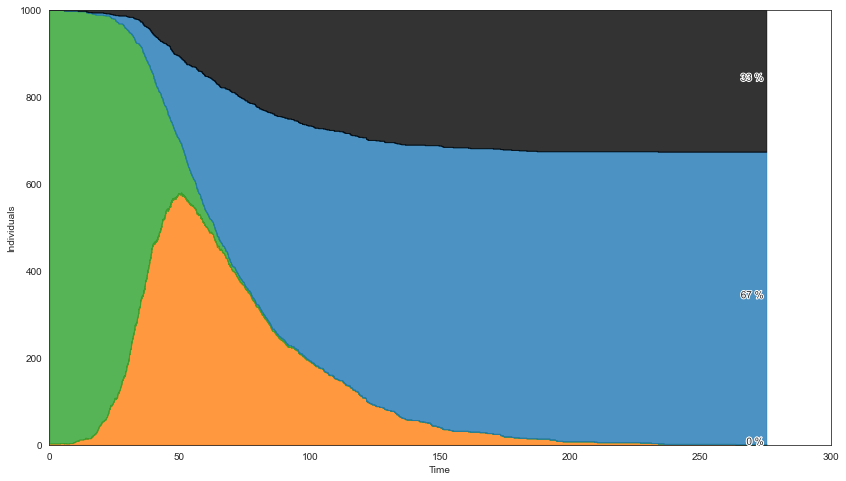

0.018354581396494846
0.014137715515598693


In [44]:
t, S, I, R, D = SIRDiotarho.simulate({'iota': 0.21, 'rho': 0.019})
fig = SIRDiotarho.plot(N, T, t, S, I, R, D, ptitle=None, figsize=figsize, plegend=False)
print(distAll2(t, S, I, R, D))
print(distIncID2(t, S, I, R, D))

In [46]:
model = SIRDiotarho
tolerance = 0.025

dist = distAll2
M = 100

priors = stats.uniform(loc=[0.,0.], scale=[1.,1.])
proposal = stats.multivariate_normal
paraminit = [0.5, 0.25]

samples, distances, z, totalSamples = ABC_MCMC(model, None, priors, tolerance, dist, None, proposal, paraminit, M, 1)

fn = "ABC_MCMC_" + model.name + f'({model.formulation})_' + f'tol{tolerance}_M{M}_' + time.strftime(timeformat)
np.savez(resdir + fn, samples=samples, distances=distances, z=z, totalSamples=totalSamples)

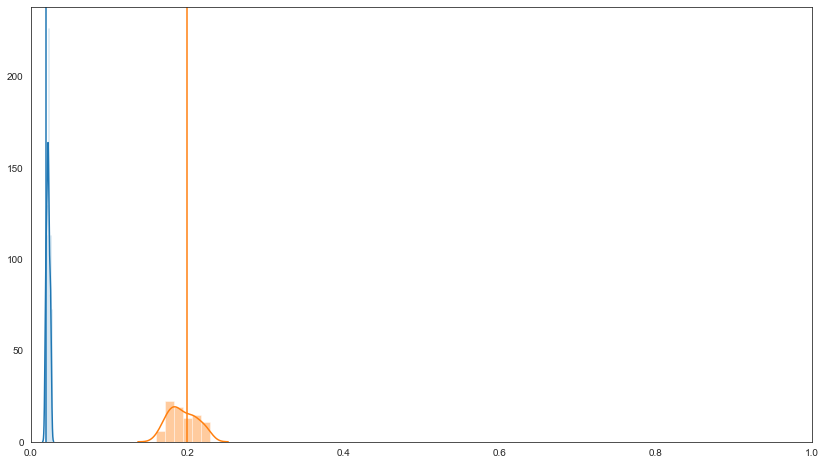

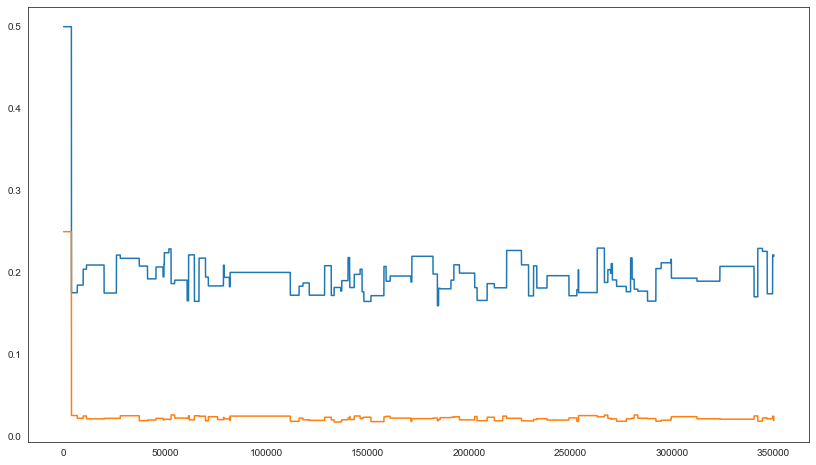

In [48]:
plt.figure(figsize=figsize)

sns.distplot(samples[:,0], color='tab:orange')
plt.axvline(iota0, c='tab:orange')
sns.distplot(samples[:,1], color='tab:blue')
plt.axvline(rho0, c='tab:blue')
#sns.distplot(samples[:,2], color='grey')
#plt.axvline(delta0, c='grey')

plt.xlim((0,1))
plt.show()


plt.figure(figsize=figsize)
plt.plot(totalSamples)
plt.show()

In [49]:
SIRDiotarhodelta = rbmf.ModelSSA(name="SIRDiotarhodelta",
                                 params={'T': 300, 'N': 1000, 'frac': 1.0, 'Iinit': np.array(3)},
                                 freeparams={'iota': 0.2,'rho': 0.02, 'delta': 0.01},
                                 update_states=updateStates,
                                 update_propensities=updatePropensities)

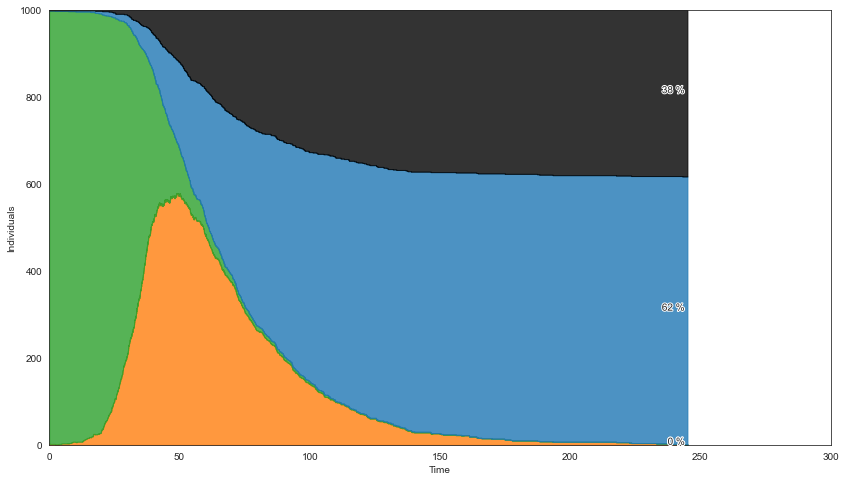

0.03040848706365284
0.016091535041754097


In [50]:
t, S, I, R, D = SIRDiotarhodelta.simulate({'iota': 0.21, 'rho': 0.019, 'delta': 0.012})
fig = SIRDiotarho.plot(N, T, t, S, I, R, D, ptitle=None, figsize=figsize, plegend=False)
print(distAll2(t, S, I, R, D))
print(distIncID2(t, S, I, R, D))

In [51]:
model = SIRDiotarhodelta
tolerance = 0.05

dist = distAll2
M = 100

priors = stats.uniform(loc=[0.,0.,0.], scale=[1.,1.,1.])
proposal = stats.multivariate_normal
paraminit = [0.5, 0.1, 0.1]

samples, distances, z, totalSamples = ABC_MCMC(model, None, priors, tolerance, dist, None, proposal, paraminit, M, 1)

In [ ]:
fn = "ABC_MCMC_" + model.name + f'({model.formulation})_' + f'tol{tolerance}_M{M}_' + time.strftime(timeformat)
np.savez(resdir + fn, samples=samples, distances=distances, z=z, totalSamples=totalSamples)

In [ ]:
plt.figure(figsize=figsize)

sns.distplot(samples[:,0], color='tab:orange')
plt.axvline(iota0, c='tab:orange')
sns.distplot(samples[:,1], color='tab:blue')
plt.axvline(rho0, c='tab:blue')
sns.distplot(samples[:,2], color='grey')
plt.axvline(delta0, c='grey')

plt.xlim((0,1))
plt.show()


plt.figure(figsize=figsize)
plt.plot(totalSamples[:,0], color='tab:orange')
plt.plot(totalSamples[:,1], color='tab:blue')
plt.plot(totalSamples[:,2], color='grey')
plt.show()